# Homework 7 Part 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sn
from sklearn import metrics
from sklearn import preprocessing as preproc

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
weekly=pd.read_csv("Weekly.csv",index_col=0)

## Part a

In [3]:
weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


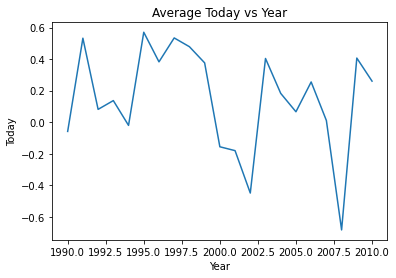

In [4]:
w = weekly.groupby("Year",as_index=False).mean()
w["Year"] = w["Year"].astype(int)
plt.plot(w['Year'],w['Today'])
plt.title("Average Today vs Year")
plt.xlabel("Year")
plt.ylabel("Today")
plt.show()

The graph aggregates the Today column into a mean over Year, giving a general idea of how the Today is distributed over time.

## Part b

In [ ]:
y = weekly[['Direction']] == 'Up'
X = sm.add_constant(weekly[['Lag1','Lag2','Lag3','Lag4','Lag5','Volume']])
log = sm.Logit(y, X).fit()
print(log.summary())

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Tue, 16 Mar 2021   Pseudo R-squ.:                0.006580
Time:                        18:36:22   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.

As we can see from the P values, Lag2 is the only predictor considered statistically significant. We may have expected Lag1 to be significant as well since these variables seemed to be really close to each other (multicolinearity maybe).

## Part c

https://datatofish.com/confusion-matrix-python/


Accuracy:  0.5610651974288338


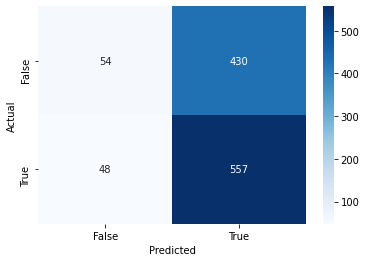

In [ ]:
y_pred = log.predict(X) > 0.5

y_vals = y.assign(Predicted = y_pred)
y_vals = y_vals.rename(columns={'Direction':'Actual'})

confusion_matrix = pd.crosstab(y_vals['Actual'], y_vals['Predicted'], rownames=['Actual'], colnames=['Predicted'])

TN = confusion_matrix.loc[0,0]
TP = confusion_matrix.loc[1,1]
FP = confusion_matrix.loc[0,1]
FN = confusion_matrix.loc[1,0]

accuracy = (TN+TP)/(TN+TP+FN+FP)
print("Accuracy: ", accuracy)

sn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

We can see from the confusion matrix that this logistic regression model is producing a lot of Type I errors (false positives). This means the model will in general default to True no matter what. As a binary outcome it will mostly be true positive or true negatives which is what would be expected of a good model. 

## Part d

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
Accuracy:  0.625


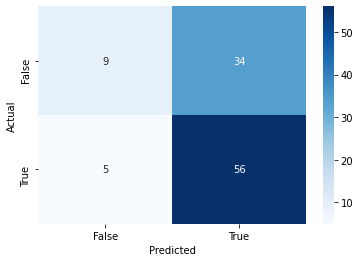

In [ ]:
weekly_train = weekly.loc[weekly['Year'] < 2009]
y_train = weekly_train[['Direction']] == 'Up'
X_train = sm.add_constant(weekly_train[['Lag2']])
log = sm.Logit(y_train, X_train).fit()

weekly_test = weekly.loc[weekly['Year'] >= 2009]
y_test = weekly_test[['Direction']] == 'Up'
X_test = sm.add_constant(weekly_test[['Lag2']])
y_pred = log.predict(X_test) > 0.5

y_vals = y_test.assign(Predicted = y_pred)
y_vals = y_vals.rename(columns={'Direction':'Actual'})

confusion_matrix = pd.crosstab(y_vals['Actual'], y_vals['Predicted'], rownames=['Actual'], colnames=['Predicted'])

TN = confusion_matrix.loc[0,0]
TP = confusion_matrix.loc[1,1]
FP = confusion_matrix.loc[0,1]
FN = confusion_matrix.loc[1,0]

accuracy = (TN+TP)/(TN+TP+FN+FP)
print("Accuracy: ", accuracy)

sn.heatmap(confusion_matrix, annot=True, cmap='Blues')
plt.show()

## Part e

Optimization terminated successfully.
         Current function value: 0.684764
         Iterations 4
Accuracy:  0.6442307692307693


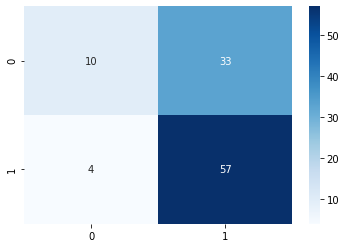

In [ ]:
scaler = preproc.StandardScaler()

weekly_train = weekly.loc[weekly['Year'] < 2009]
y_train = weekly_train[['Direction']] == 'Up'
X_train = pd.DataFrame([weekly_train['Lag2'],weekly_train.iloc[:,3:6].sum(axis=1)]).T

weekly_test = weekly.loc[weekly['Year'] >= 2009]
y_test = weekly_test[['Direction']] == 'Up'
X_test = pd.DataFrame([weekly_test['Lag2'],weekly_test.iloc[:,3:6].sum(axis=1)]).T

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) 

X_train = sm.add_constant(X_train)
log = sm.Logit(y_train, X_train).fit()
X_test = sm.add_constant(X_test)
y_pred = log.predict(X_test) >= .5

y_vals = y_test.assign(Predicted = y_pred)
y_vals = y_vals.rename(columns={'Direction':'Actual'})

confusion_matrix = metrics.confusion_matrix(y_vals['Actual'], y_vals['Predicted'])
TN = confusion_matrix[0,0]
TP = confusion_matrix[1,1]
FP = confusion_matrix[0,1]
FN = confusion_matrix[1,0]

accuracy = (TN+TP)/(TN+TP+FN+FP)
print("Accuracy: ", accuracy)

sn.heatmap(confusion_matrix, annot=True, cmap='Blues')

To increase the accuracy, we used Lag 2 and the sum of Lag 3, Lag 4, and Lag 5 as the input. Then we normalized the data using StandardScaler and outputted the corresponding confusion matrix/accuracy.